## Draw point in image

In [2]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

In [3]:
def draw_points(image, points):
    idx = -1
    for pt in points:
        idx += 1
        pt = (int(pt[0]), int(pt[1]))
        cv2.circle(image, pt, 5, (255,0,0), -1)
        cv2.putText(image, str(idx), pt, cv2.FONT_HERSHEY_COMPLEX, 1.0, (0,0,255))
    return image

def draw_landmarks(img, landmark):
    landmark = landmark
    lm_img = np.zeros([img.shape[0], img.shape[1], 3])
    lm_img[:] = img.astype(np.float32)
    landmark = np.round(landmark).astype(np.int32)

    for i in range(len(landmark)):
        for j in range(-1, 1):
            for k in range(-1, 1):
                if img.shape[0] - 1 - landmark[i, 1]+j > 0 and \
                        img.shape[0] - 1 - landmark[i, 1]+j < img.shape[0] and \
                        landmark[i, 0]+k > 0 and \
                        landmark[i, 0]+k < img.shape[1]:
                    lm_img[img.shape[0] - 1 - landmark[i, 1]+j, landmark[i, 0]+k,
                           :] = np.array([0, 0, 255])
    lm_img = lm_img.astype(np.uint8)

[[217.63197197 158.44200938]
 [217.89065443 167.05815268]
 [219.67573759 175.7623368 ]
 [224.40656369 195.93587044]
 [222.31882824 175.96444968]
 [221.27308348 166.91718394]
 [220.614851   158.46222966]
 [219.01439169 140.56963124]
 [210.70511559 149.12499005]
 [206.83761338 158.25415972]
 [207.0035568  167.96353565]
 [208.9340259  177.73760748]
 [214.63931438 187.05662748]
 [224.17503643 199.23169735]
 [227.50763975 186.38007423]
 [229.47258111 172.43004819]
 [227.22546625 165.84014777]
 [228.12733119 159.03575952]
 [223.80820526 147.13715335]
 [218.46103716 138.61582845]
 [302.38227892 194.18074117]
 [303.83561012 206.40848044]
 [309.69042076 214.97587701]
 [312.20868295 205.46180269]
 [310.91434901 194.21207755]
 [304.49440459 184.79991388]
 [293.88115181 118.25217472]
 [295.00472048 129.89572886]
 [299.11561911 139.42765188]
 [303.26278836 128.31845713]
 [301.87277058 117.11499473]
 [297.56767184 109.77000904]
 [249.96526698 178.95975985]
 [247.34544257 172.36217145]
 [244.60945552

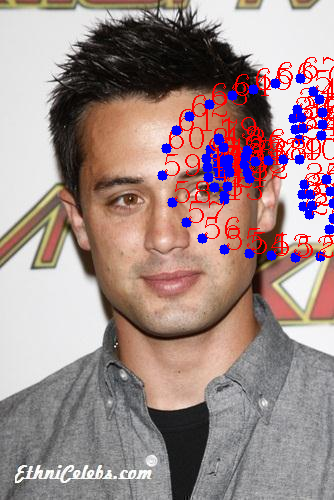

In [10]:
image_path = "/home/haimingzhang/Research/Face/Deep3DFaceReconstruction/input/vd025.png"
landmark_path = "/home/haimingzhang/Research/Face/Deep3DFaceReconstruction/input/vd025.txt"

image_path = "/home/haimingzhang/Research/Programming/cv-fighter/face_fighter/gangqiang-2-512x512/000001.jpg"
landmark_path = "/home/haimingzhang/Research/Programming/cv-fighter/face_fighter/gangqiang-2-512x512/000001.txt"

image_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/000002.jpg"
landmark_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/detections/000002.txt"

image_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/000007.jpg"
landmark_path = "/home/haimingzhang/Research/Deep3DFaceRecon_pytorch/datasets/examples/landmarks/000007.txt"

img_src = cv2.imread(image_path)
# display(Image.fromarray(img_src[..., ::-1]))


landmarks = np.loadtxt(landmark_path)[::-1, :]
print(landmarks, landmarks.shape)

draw_points(img_src, landmarks)
display(Image.fromarray(img_src[..., ::-1]))
